# ISYE6420 Fall 2019 HW3 Supplement

---
**Course:** ISYE6420                 
**Term:** Fall 2019    
**Author:** James D. Triveri   
**Date:** 2019-09-29     
**Synopsis:** A numerical routine used for determining highest posterior density (HPD) credible sets for unimodal densities.   
**Problems:** 1.C, 2.B, 2.C

---

## Introduction


For roughly symmetric distributions, the equi-tailed credible set variant is usually sufficient. However for skewed distributions, the $(1- \alpha)100\%$ HPD  variant is preferable. 
<br>

From Prof Vidakovic's *Engineering Biostatistics*, Chapter 8 pp. 355-57, it is stated that the $(1- \alpha)100\%$ HPD credible set for parameter $\theta$ is a set $C$, a subset of parameter space $\Theta$, of the form:

<br>

$$
C = \{\theta \in \Theta|\pi(\theta|x) \geq k(\alpha)\},
$$

<br>

where $k(\alpha)$ is the largest constant for which $\mathbf{P}(\theta \in C|X) \geq 1- \alpha$. He goes on to describe further properties of $k(\alpha)$:

> Geometrically, if the posterior density is cut by a horizontal line at the height $k(\alpha)$, the credible set $C$ is the projection > on the $\theta$-axis of the part of the line that lies below the denisty.


Note that "k-alpha" is represented as $k(\alpha)$ in Dr. Vidakovic's text, but as $k_{\alpha}$ in ISYE6420's lecture slides. The interpretation is the same, but I will use notation consistent with the text, $k(\alpha)$. 

<br>

## Implementation

---

The algorithm identifies $(1- \alpha)100\%$ HPD credible sets for unimodal distributions. Although the implementation has not been tested on multimodal distributional forms, it would almost surely not identify the level corresponding to the highest posterior  density.      
<br>
Note that the implementation parameterizes the gamma distribution in terms of shape-scale as opposed to shape-rate as stated in the problem. This is to remain consistent with Scipy's gamma parameterization. An outline of the update routine (embedded within the `HPD` declaration below) is as follows:    


1. Compute the mode of the posterior density, and evaluate the PDF at that value.       
<br>
2. Initial proposed $k(\alpha)$ is set to the horizontal line mid-way between the posterior density evaluated at the mode and the          horizontal line $f(x) = 0$. We identify the points at which the proposed $k(\alpha)$ line intersects the posterior density, then        compute the area under the density bounded by the points of intersection.        
<br>
3. If the area under the curve is less than $1 - \alpha$, the updated $k(\alpha)$ proposal is mid-way between $f(x)=0$ and the previous   $k(\alpha)$ proposal. If the area under the curve exceeds $1 - \alpha$, updated $k(\alpha)$ proposal is mid-way between the posterior    density evaluated at the mode and the previous $k(\alpha)$ proposal.    
<br>
4. Iteration continues in this manner until the area under the curve converges to $1 - \alpha$ within a pre-specified tolerance (1e-8 by default).
<br>


In [1]:
"""
Logic to compute (1-a)100% HPD credible set and associated level k-alpha. 

"""
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, special, optimize



def _beta(a, b):
    """
    Beta distribution closure. Returns a parameterized beta density, which 
    takes a single argument x and returns the corresponding beta PDF 
    evaluated at that point.
    
    Parameters
    ----------
    a: float
        Shape parameter. Must be greater than 0. 
        
    b: float
        Shape parameter. Must be greater than 0. 
    
    """
    def _pdf(x):
        """Evaluate parameterized gamma PDF at x."""
        coeff = special.gamma(a + b) / (special.gamma(a) * special.gamma(b))
        return(coeff * np.power(x, a - 1) * np.power(1 - x, b - 1))
    return(_pdf)



def _gamma(alpha, theta):
    """
    Gamma distribution closure. Note that the distribution is parameterized
    using shape-scale as opposed to shape-rate. We re-implement the gamma 
    distribution instead of using scipy.stats.gamma since we need to determine
    the intersection points for each candidate k(a) with the target gamma 
    density. Returns a parameterized gamma density, which takes a single 
    argument x and returns the corresponding gamma PDF evaluated at that 
    point.
    
    Parameters
    ----------
    alpha: float
        Shape parameter. Must be greater than 0. 
        
    theta: float
        Scale parameter. Must be greater than 0. 
    
    """
    def _pdf(x):
        """Evaluate parameterized gamma PDF at x."""
        return((np.power(x, alpha - 1) * np.exp(-x / theta)) / 
               (special.gamma(alpha) * np.power(theta, alpha)))
    return(_pdf)



def _intersection(func1, func2, xinit):
    """
    Identify the points of intersection for func1 and func2. 
    
    Parameters
    ----------
    func1: function
        A callable that takes a single argument. 
        
    func2: function
        A callable that takes a single argument. 
    
    xinit: list
        The starting estimates for the intersection points of func1 and func2. 
    """
    return(optimize.fsolve(lambda x: func1(x) - func2(x), xinit))



def HPD1(shape, scale, alpha=.05, niter=50, tol=1e-8):
    """
    Perform binary search over posterior density in order to identify
    the level k-alpha (1-alpha)100% HPD credible set for gamma density. 
    
    Parameters
    ----------
    shape: float
        Shape parameter. Must be greater than 0. 
        
    scale: float
        Scale parameter. Must be greater than 0. 
        
    alpha: float
        The level used to determine the calculated credible set. 
        Identified HPD will correspond to area under posterior density
        equal to 1- alpha. 
    
    niter: int
        The number of iterations to compute prior to terminating. 
        Should rarely exceed 30. 
        
    tol: float
        The equivalence threshold used to indicate when the HPD
        credible set has been identified. 
    
    Returns
    -------
    A dictionary comprised of the following keys:
    
    iterations: int
        Number of iterations before convergence.
    
    k_alpha: float
        The k(alpha) value for which the area under the posterior
        density equals 1 - alpha. 
    
    k_roots: list
        The upper and lower bounds of the (1 - alpha)100% HPD credible set. 
    
    auc: float
        The final area under the posterior density. Bound between [0, 1]. 
    
    alpha: float
        The level used to determine the calculated credible set. Input. 
        
    niter: int
        The number of iterations to compute prior to terminating. Input.
        
    tol: float
        The equivalence threshold used to indicate when the HPD
        credible set has been identified. 
        
    shape: float
        Shape parameter. Must be greater than 0. Input.
        
    scale: float
        Scale parameter. Must be greater than 0. Input.
            
    rv: scipy.stats._distn_infrastructure.rv_frozen
        The frozen, parameterized posterior distribution.
    """ 
    randv       = stats.gamma(a=shape, scale=scale) 
    randv_mode  = (shape - 1) * scale          # mode of distribution
    hpd         = 1 - alpha                    # area under posterior density
    randv_max   = randv.pdf(randv_mode)        # density @ posterior mode
    randv_min   = 0                            # posterior minimum
    xinit   = [randv.ppf(.05), randv.ppf(.95)] #  starting estimates
    k_alpha = (randv_max + randv_min) / 2.     # proposed k-alpha
    func1   = _gamma(alpha=shape, theta=scale) # density obtained from _gamma
    func2   = lambda x: k_alpha                # horizontal line f(x) = k_alpha
    k_roots = _intersection(func1=func1, func2=func2, xinit=xinit) 
    auc     = randv.cdf(k_roots[-1]) - randv.cdf(k_roots[0]) # area under curve

    for i in itertools.count(start=1):
        
        print(
            "[#{}] proposed k({:.2f}):{:.10f} - auc:{:.10f} - [{:.5f}, {:.5f}]".format(
            i, alpha, k_alpha, auc, k_roots[0], k_roots[-1])
            )
        
        if i > niter:
            print("Iteration failed to converge after 50 iterations - exiting.")
            break
    
        if np.abs(auc - hpd) < tol: 
            break
            
        if auc < hpd:
            randv_max, randv_min = k_alpha, randv_min
        else:
            randv_max, randv_min = randv_max, k_alpha
               
        k_alpha = (randv_max + randv_min) / 2.
        k_roots = _intersection(func1=func1, func2=func2, xinit=k_roots)
        auc  = randv.cdf(k_roots[-1]) - randv.cdf(k_roots[0])
        
    dresult = {
        "iterations":i, "k_alpha":k_alpha, "k_roots":k_roots, 
        "auc":auc, "alpha":alpha, "niter":niter, "tol":tol, 
        "shape":shape, "scale":scale, "rv":randv
        }
    
    return(dresult)




def HPD2(a, b, alpha=.05, niter=50, tol=1e-8):
    """
    Perform binary search over posterior density in order to identify
    the level k-alpha (1-alpha)100% HPD credible set for beta density.
    
    Parameters
    ----------
    a: float
        Shape parameter. Must be greater than 0. 
        
    b: float
        Shape parameter. Must be greater than 0. 
        
    alpha: float
        The level used to determine the calculated credible set. 
        Identified HPD will correspond to area under posterior density
        equal to 1- alpha. 
    
    niter: int
        The number of iterations to compute prior to terminating. 
        Should rarely exceed 30. 
        
    tol: float
        The equivalence threshold used to indicate when the HPD
        credible set has been identified. 
    
    Returns
    -------
    A dictionary comprised of the following keys:
    
    iterations: int
        Number of iterations before convergence.
    
    k_alpha: float
        The k(alpha) value for which the area under the posterior
        density equals 1 - alpha. 
    
    k_roots: list
        The upper and lower bounds of the (1 - alpha)100% HPD credible set. 
    
    auc: float
        The final area under the posterior density. Bound between [0, 1]. 
    
    alpha: float
        The level used to determine the calculated credible set. Input. 
        
    niter: int
        The number of iterations to compute prior to terminating. Input.
        
    tol: float
        The equivalence threshold used to indicate when the HPD
        credible set has been identified. 
        
    a: float
        Shape parameter. Must be greater than 0. 
        
    b: float
        Shape parameter. Must be greater than 0. 
            
    rv: scipy.stats._distn_infrastructure.rv_frozen
        The frozen, parameterized posterior distribution.
    """ 
    randv      = stats.beta(a=a, b=b) 
    randv_mode = (a - 1) / (a + b - 2)        # mode of distribution
    hpd        = 1 - alpha                    # area under posterior density
    randv_max  = randv.pdf(randv_mode)        # density @ posterior mode
    randv_min  = 0                            # posterior minimum
    xinit   = [randv.ppf(.05), randv.ppf(.95)] # starting estimates
    k_alpha = (randv_max + randv_min) / 2.     # proposed k-alpha
    func1   = _beta(a=a, b=b)                  # density obtained from _beta
    func2   = lambda x: k_alpha                # horizontal line f(x) = k_alpha
    k_roots = _intersection(func1=func1, func2=func2, xinit=xinit) 
    auc     = randv.cdf(k_roots[-1]) - randv.cdf(k_roots[0]) # area under curve

    for i in itertools.count(start=1):
        
        print(
            "[#{}] proposed k({:.2f}):{:.10f} - auc:{:.10f} - [{:.5f}, {:.5f}]".format(
            i, alpha, k_alpha, auc, k_roots[0], k_roots[-1])
            )
        
        if i > niter:
            print("Iteration failed to converge after 50 iterations - exiting.")
            break
    
        if np.abs(auc - hpd) < tol: 
            break
            
        if auc < hpd:
            randv_max, randv_min = k_alpha, randv_min
        else:
            randv_max, randv_min = randv_max, k_alpha
               
        k_alpha = (randv_max + randv_min) / 2.
        k_roots = _intersection(func1=func1, func2=func2, xinit=k_roots)
        auc  = randv.cdf(k_roots[-1]) - randv.cdf(k_roots[0])
        
    dresult = {
        "iterations":i, "k_alpha":k_alpha, "k_roots":k_roots, 
        "auc":auc, "alpha":alpha, "niter":niter, "tol":tol, 
        "a":a, "b":b, "rv":randv
        }
    
    return(dresult)


# Problem 1.C

In [2]:
# Specify parameters and set initial values.
SHAPE = 5        # gamma shape parameter, "alpha"
RATE  = 1 / 28.  # gamma rate  parameter, "lambda"
SCALE = 1 / RATE # gamma scale parameter, "theta" 
ALPHA = .05      # used in determining (1- ALPHA)100% credible set
NITER = 50       # max number of kalpha proposals
TOL   = 1e-8     # equivalence threshold

# Call HPD and bind references to relevant output.
dresult = HPD1(shape=SHAPE, scale=SCALE, alpha=ALPHA, niter=NITER, tol=TOL)
kalpha  = dresult["k_alpha"]
kroots  = dresult["k_roots"]
rv      = dresult["rv"]


[#1] proposed k(0.05):0.0034886931 - auc:0.7512684424 - [58.31772, 191.46069]
[#2] proposed k(0.05):0.0017443466 - auc:0.8972292823 - [42.62945, 232.73157]
[#3] proposed k(0.05):0.0008721733 - auc:0.9543595594 - [32.84955, 267.90212]
[#4] proposed k(0.05):0.0013082599 - auc:0.9270350232 - [38.09821, 247.82395]
[#5] proposed k(0.05):0.0010902166 - auc:0.9410121301 - [35.59665, 257.00176]
[#6] proposed k(0.05):0.0009811949 - auc:0.9477658356 - [34.25993, 262.19060]
[#7] proposed k(0.05):0.0009266841 - auc:0.9510829141 - [33.56492, 264.97357]
[#8] proposed k(0.05):0.0009539395 - auc:0.9494293986 - [33.91484, 263.56491]
[#9] proposed k(0.05):0.0009403118 - auc:0.9502574159 - [33.74050, 264.26483]
[#10] proposed k(0.05):0.0009471257 - auc:0.9498437216 - [33.82782, 263.91378]
[#11] proposed k(0.05):0.0009437187 - auc:0.9500506474 - [33.78420, 264.08903]
[#12] proposed k(0.05):0.0009454222 - auc:0.9499472042 - [33.80602, 264.00134]
[#13] proposed k(0.05):0.0009445705 - auc:0.9499989307 - [33.

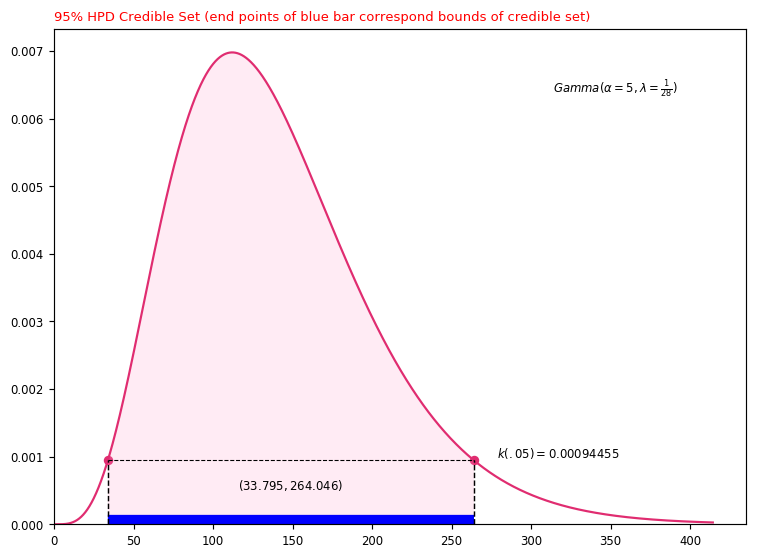

In [3]:
"""
Visualize the (1 - alpha)100% HPD credible set of the gamma posterior.
"""
x    = np.arange(0, rv.ppf(.999), .01, dtype=np.float32)
y    = rv.pdf(x)
yl   = np.asarray([y.max() / 50. for i in x], np.float32) # Used to represent credible set span
eqcs = [rv.ppf(.025), rv.ppf(.975)] # equi-tailed credible set
eqs  = eqcs[-1] - eqcs[0]

titlestr = "95% HPD Credible Set (end points of blue bar correspond bounds of credible set)"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8.5, 6.25), dpi=105) 

ax.plot(x, y, color="#E02C70")
ax.scatter(kroots[0], kalpha, s=30, color="#E02C70")
ax.scatter(kroots[-1], kalpha, s=30, color="#E02C70")

ax.plot([kroots[0], kroots[0]], [0, kalpha], linestyle="--", 
        linewidth=1.0, color="#000000")
ax.plot([kroots[-1], kroots[-1]], [0, kalpha], linestyle="--", 
        linewidth=1.0, color="#000000")
ax.plot([kroots[0], kroots[-1]], [kalpha, kalpha], linestyle="--", 
        linewidth=.75, color="#000000")

ax.set_ylim(bottom=0)
ax.set_xlim(0)
ax.set_ylim(0)

ax.fill_between(x, y, where=np.logical_and(x<=kroots[-1], x>=kroots[0]), 
                facecolor="#ff9ccb", alpha=0.20)
ax.fill_between(x, yl, where=np.logical_and(x<=kroots[-1], x>=kroots[0]), 
                facecolor="blue", alpha=1.)

ax.set_title(titlestr, color="red", loc="left", fontsize=9)
ax.tick_params(axis="x", which="major", labelsize=8)
ax.tick_params(axis="x", which="minor", labelsize=8)
ax.tick_params(axis="y", which="major", labelsize=8)
ax.tick_params(axis="y", which="minor", labelsize=8)
ax.grid(False)

# Embed value of k(alpha).
ax.annotate(
    r"$k(.05)={:.8f}$".format(kalpha), (kroots[-1], kalpha), xytext=(57.5, 0), 
    textcoords="offset points", ha="center", va="bottom", fontsize=8, 
    rotation=0, color="#000000"
    )

# Overlay (1 - alpha)100% HPD credible set.
ax.annotate(
    r"$({:.3f}, {:.3f})$".format(kroots[0], kroots[-1]), 
    ((kroots[0] + kroots[-1]) / 2., kalpha / 2.), xytext=(0, 0), 
    textcoords="offset points", ha="center", va="bottom", 
    fontsize=8, rotation=0, color="#000000"
    )

# Overlay parameters of posterior gamma distribution from HW3 problem 1.c.
ax.annotate(
    r'$Gamma(\alpha=5, \lambda=\frac{1}{28})$', (rv.ppf(.995), y.max() * .90), 
    xytext=(0, 0), textcoords="offset points", ha="center", va="bottom", 
    fontsize=8, rotation=0, color="#000000"
    )

plt.show()


## Problem 1.C Results

---
- $k(.05) \approx .00094455$.         
<br>  
- 95% HPD credible set: $[33.79488, 264.04607]$.        
<br>     
- HPD credible set span: $L = 264.04607 - 33.79488 \approx 230.25119$.    
<br>
- 95% equi-tailed credible set: $[45.45762, 286.76448]$.    
<br>
- Equi-tailed credible set span: $L = 286.76448 - 45.45762 \approx 241.30686$.
---


<br>

# Problem 2.B

In [4]:
# Specify parameters and set initial values.
a_prior     = 31.5 # elicited
b_prior     = 3.5  # elicited
a_posterior = 22 + a_prior
b_posterior = 30 - 22 + b_prior
ALPHA       = .05      
NITER       = 50       
TOL         = 1e-8     

# Call HPD and bind references to relevant output.
dresult = HPD2(a=a_posterior, b=b_posterior, alpha=ALPHA, niter=NITER, tol=TOL)
kalpha  = dresult["k_alpha"]
kroots  = dresult["k_roots"]
rv      = dresult["rv"]


[#1] proposed k(0.05):4.2805087214 - auc:0.7644950943 - [0.77339, 0.88357]
[#2] proposed k(0.05):2.1402543607 - auc:0.9065802893 - [0.74606, 0.90133]
[#3] proposed k(0.05):1.0701271803 - auc:0.9600829663 - [0.72423, 0.91374]
[#4] proposed k(0.05):1.6051907705 - auc:0.9347403806 - [0.73655, 0.90692]
[#5] proposed k(0.05):1.3376589754 - auc:0.9477729793 - [0.73087, 0.91012]
[#6] proposed k(0.05):1.2038930779 - auc:0.9540203382 - [0.72770, 0.91186]
[#7] proposed k(0.05):1.2707760267 - auc:0.9509194430 - [0.72932, 0.91098]
[#8] proposed k(0.05):1.3042175010 - auc:0.9493518738 - [0.73010, 0.91054]
[#9] proposed k(0.05):1.2874967639 - auc:0.9501370780 - [0.72971, 0.91076]
[#10] proposed k(0.05):1.2958571325 - auc:0.9497448303 - [0.72991, 0.91065]
[#11] proposed k(0.05):1.2916769482 - auc:0.9499410428 - [0.72981, 0.91070]
[#12] proposed k(0.05):1.2895868560 - auc:0.9500390826 - [0.72976, 0.91073]
[#13] proposed k(0.05):1.2906319021 - auc:0.9499900682 - [0.72978, 0.91072]
[#14] proposed k(0.05

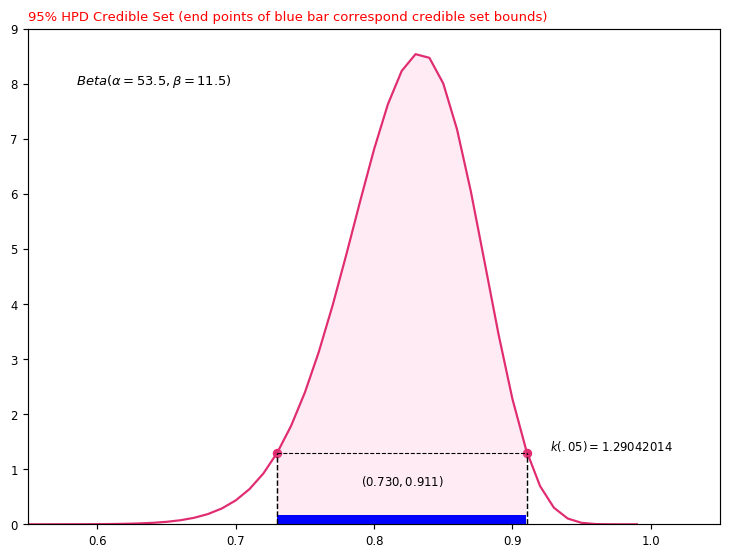

In [6]:
"""
Visualize the (1 - alpha)100% HPD credible set of the beta posterior. 
"""
x    = np.arange(0, rv.ppf(1), .01, dtype=np.float32)
y    = rv.pdf(x)
yl   = np.asarray([y.max() / 50. for i in x], np.float32) # Used to represent credible set span
eqcs = [rv.ppf(.025), rv.ppf(.975)] # equi-tailed credible set
eqs  = eqcs[-1] - eqcs[0]

titlestr = "95% HPD Credible Set (end points of blue bar correspond credible set bounds)"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8.5, 6.25), dpi=105) 

ax.plot(x, y, color="#E02C70")
ax.scatter(kroots[0], kalpha, s=30, color="#E02C70")
ax.scatter(kroots[-1], kalpha, s=30, color="#E02C70")

ax.plot([kroots[0], kroots[0]], [0, kalpha], linestyle="--", 
        linewidth=1.0, color="#000000")
ax.plot([kroots[-1], kroots[-1]], [0, kalpha], linestyle="--", 
        linewidth=1.0, color="#000000")
ax.plot([kroots[0], kroots[-1]], [kalpha, kalpha], linestyle="--", 
        linewidth=.75, color="#000000")

ax.set_ylim(bottom=0, top=9)
ax.set_xlim(.55, 1.05)


ax.fill_between(x, y, where=np.logical_and(x<=kroots[-1], x>=kroots[0]), 
                facecolor="#ff9ccb", alpha=0.20)
ax.fill_between(x, yl, where=np.logical_and(x<=kroots[-1], x>=kroots[0]), 
                facecolor="blue", alpha=1.)

ax.set_title(titlestr, color="red", loc="left", fontsize=9)
ax.tick_params(axis="x", which="major", labelsize=8)
ax.tick_params(axis="x", which="minor", labelsize=8)
ax.tick_params(axis="y", which="major", labelsize=8)
ax.tick_params(axis="y", which="minor", labelsize=8)
ax.grid(False)

# Embed value of k(alpha).
ax.annotate(
    r"$k(.05)={:.8f}$".format(kalpha), (kroots[-1], kalpha), xytext=(57.5, 0), 
    textcoords="offset points", ha="center", va="bottom", fontsize=8, 
    rotation=0, color="#000000"
    )

# Overlay (1 - alpha)100% HPD credible set.
ax.annotate(
    r"$({:.3f}, {:.3f})$".format(kroots[0], kroots[-1]), 
    ((kroots[0] + kroots[-1]) / 2., kalpha / 2.), xytext=(0, 0), 
    textcoords="offset points", ha="center", va="bottom", 
    fontsize=8, rotation=0, color="#000000"
    )

# Overlay parameters of posterior gamma distribution from HW3 problem 1.c.
ax.annotate(
    r'$Beta(\alpha=53.5, \beta=11.5)$', (rv.ppf(.0005), y.max() * .925), 
    xytext=(0, 0), textcoords="offset points", ha="center", va="bottom", 
    fontsize=9, rotation=0, color="#000000"
    )

plt.show()


## Problem 2.B Results

---
- $k(.05) \approx 1.29042014$.         
<br>  
- 95% HPD credible set: $[0.72978, 0.91072]$.          
<br>        
- Credible set span: $L =  0.91072 - 0.72978 \approx .18094$.     
<br>
- 95% equi-tailed credible set: $[0.72227, 0.90510]$.       
<br>
- Equi-tailed credible set span: $L = 0.90510 - 0.72227 \approx 0.18283$.   
---


<br>

# Problem 2.C

Test the hypothesis $H_{0}: p \geq 4/5$ against the alternative $H_{1}: p < 4/5$.

In [2]:
import numpy as np
from scipy import stats

# Initialize parameters.
a_prior      = 31.5
b_prior      = 3.5
a_posterior  = 22 + a_prior
b_posterior  = 30 - 22 + b_prior
rv_prior     = stats.beta(a=a_prior, b=b_prior)
rv_posterior = stats.beta(a=a_posterior, b=b_posterior)

p0  = rv_posterior.sf(4 / 5) # p >= 4 / 5 (posterior)
p1  = 1 - p0                 # p <= 4 / 5 (posterior)
pi0 = rv_prior.sf(4 / 5)     # p >= 4 / 5 (prior)
pi1 = 1 - pi0                # p <= 4 / 5 (prior)

posterior_ratio = p0 / p1
prior_ratio     = pi0 / pi1
B_01            = posterior_ratio / prior_ratio
B_01_log10      = np.log10(B_01)
B_10            = 1 / B_01
B_10_log10      = np.log10(B_10)

print("p0         : {}".format(p0))
print("p1         : {}".format(p1))
print("pi0        : {}".format(pi0))
print("pi1        : {}".format(pi1))
print("p0/p1      : {}".format(posterior_ratio))
print("pi0/pi1    : {}".format(prior_ratio))
print("B_01       : {}".format(B_01))
print("B_10       : {}".format(B_10))
print("log10(B_01): {}".format(B_01_log10))


p0         : 0.7054276868567004
p1         : 0.29457231314329957
pi0        : 0.9585048458310056
pi1        : 0.04149515416899441
p0/p1      : 2.394752172494682
pi0/pi1    : 23.099199533694225
B_01       : 0.10367251769921797
B_10       : 9.645757836240369
log10(B_01): -0.9843363544441778


## Problem 2.C Results

Since $B_{01} = 0.10367$ and $log_{10}B_{01} = log_{10}(.10367) = -.98435$, we obtain $log_{10}B_{10} = log_{10}(9.64576) = .98435$. Looking up the Bayes Factor Calibration, we find that $0.5 < log_{10}B_{10} \leq 1$ implies *substantial evidence against $H_{0}$.*